# Проект RL: Трек 1 (Pendulum-v1) + Трек 2 (GridWorld)

Этот ноутбук обучает агентов, проводит контролируемые эксперименты, логирует результаты и сохраняет артефакты (графики, CSV, видео).
Предположение: запускать из корня проекта, чтобы локальные модули импортировались.


## Настройка


In [1]:
!pip -q install gymnasium==0.29.1 stable-baselines3==2.3.2 torch==2.2.2 numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 imageio==2.34.0 imageio-ffmpeg==0.4.9 tensorboard==2.16.2 pygame==2.5.2

In [2]:
import sys
from pathlib import Path

import gymnasium as gym
import matplotlib
import numpy as np
import pandas as pd
import stable_baselines3 as sb3
import torch

from IPython.display import Image, Video, display

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "track1").exists():
    print("WARNING: run this notebook from the project root (track1/track2/utils should exist).")

sys.path.append(str(PROJECT_ROOT))

from utils.seed import set_global_seed

set_global_seed(42)
print("gymnasium", gym.__version__)
print("stable-baselines3", sb3.__version__)
print("torch", torch.__version__)
print("cuda_available", torch.cuda.is_available())
if torch.cuda.is_available():
    print("cuda_device", torch.cuda.get_device_name(0))
    print("cuda_version", torch.version.cuda)

print("numpy", np.__version__)
print("pandas", pd.__version__)
print("matplotlib", matplotlib.__version__)

gymnasium 0.29.1
stable-baselines3 2.3.2
torch 2.2.2+cu121
cuda_available True
cuda_device NVIDIA GeForce RTX 3080
cuda_version 12.1
numpy 1.26.4
pandas 2.2.2
matplotlib 3.8.4


## Трек 1: Pendulum-v1

Эксперимент 1: PPO vs SAC (одинаковое число шагов, сиды, протокол оценки).
Гипотеза: SAC быстрее достигает более высокого среднего вознаграждения за счет повторного использования выборок вне политики.

Эксперимент 2: PPO с малой и большой сетью (одинаковые гиперпараметры PPO).
Гипотеза: более крупная сеть улучшает итоговое вознаграждение, но может быть менее стабильной на ранних этапах.

Примечание: чтобы время выполнения оставалось разумным, в этом запуске используется 10k шагов и один сид. Устройство по умолчанию - CUDA; если GPU недоступен, добавьте `--device cpu` или переключите среду выполнения на GPU.


In [6]:
# Train experiment 1: PPO vs SAC
!python track1/train.py --experiment exp1 --seeds 47 --timesteps 10000 --device cuda

In [7]:
# Train experiment 2: PPO small vs PPO large
!python track1/train.py --experiment exp2 --seeds 47 --timesteps 10000

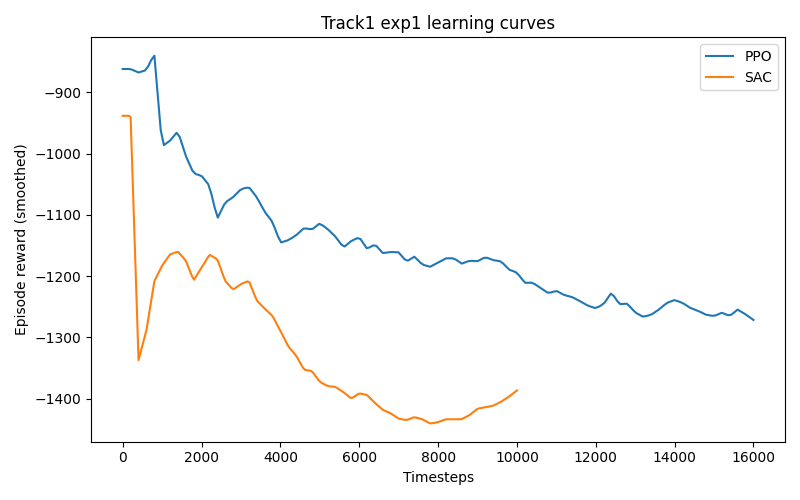

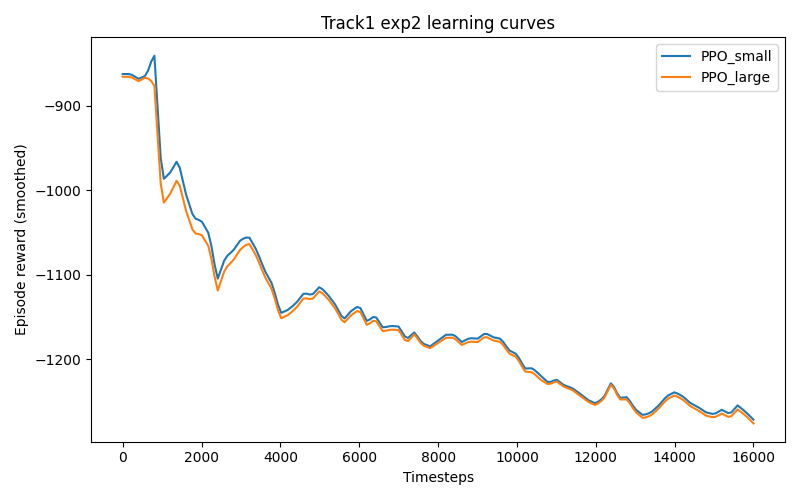

In [8]:
# Plot learning curves
!python track1/plot_learning_curves.py --experiment exp1 --seeds 47
!python track1/plot_learning_curves.py --experiment exp2 --seeds 47

display(Image(filename="track1/artifacts/plots/exp1_learning_curve.png"))
display(Image(filename="track1/artifacts/plots/exp2_learning_curve.png"))

In [9]:
# Evaluate and save CSV summaries
!python track1/evaluate.py --experiment exp1 --seeds 47 --n_eval_episodes 20
!python track1/evaluate.py --experiment exp2 --seeds 47 --n_eval_episodes 20 --record_video

exp1_summary = pd.read_csv("track1/artifacts/plots/exp1_eval_summary.csv")
exp2_summary = pd.read_csv("track1/artifacts/plots/exp2_eval_summary.csv")

display(exp1_summary)
display(exp2_summary)

S:\DEV\CODE\AVITO\vo_PJ_1\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0000023fb6f41fc0] Warning: data is not aligned! This can lead to a speed loss


,experiment,variant,mean_reward,std_reward
0,exp1,PPO,-1148.038016,NaN
1,exp1,SAC,-971.815367,NaN


,experiment,variant,mean_reward,std_reward
0,exp2,PPO_large,-1132.963023,NaN
1,exp2,PPO_small,-1148.038016,NaN


In [10]:
# Show the recorded video for the best Track 1 variant (from exp2)
from pathlib import Path
videos = sorted(Path("track1/artifacts/videos").glob("*.mp4"))
if videos:
    display(Video(str(videos[-1]), embed=True))
else:
    print("No video found in track1/artifacts/videos")

## Трек 2: Пользовательский GridWorld

Гипотеза: плотное вознаграждение ускоряет обучение и повышает успешность по сравнению с разреженным вознаграждением.
Сетка: 4x4, одна яма, max_steps=30.


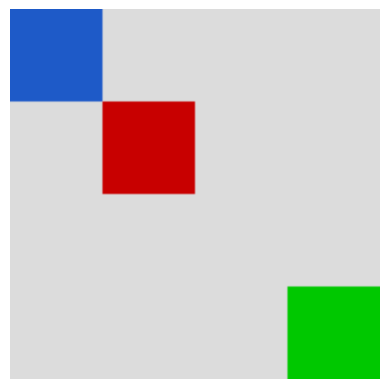

In [11]:
from track2.envs.gridworld import GridWorldEnv
import matplotlib.pyplot as plt

env = GridWorldEnv(reward_mode="dense", render_mode="rgb_array")
obs, _ = env.reset()
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [13]:
# Train sparse vs dense reward variants
!python track2/train.py --variants sparse,dense --seeds 50 --timesteps 30000 --device cuda

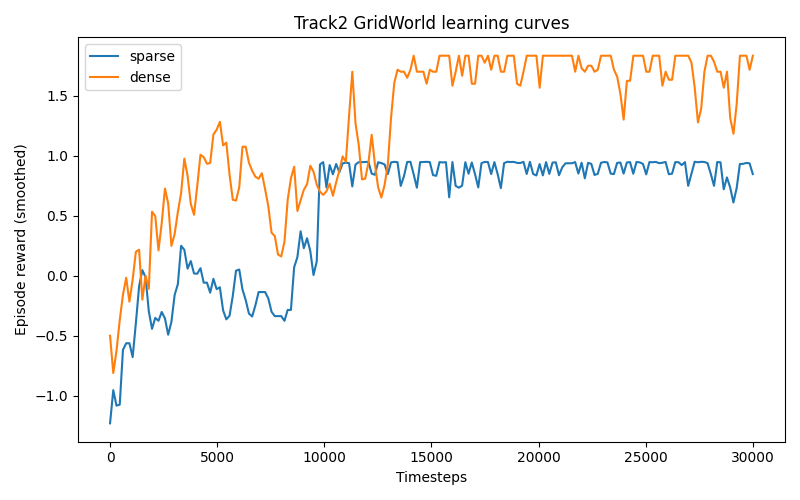

In [14]:
# Plot learning curves
!python track2/plot_learning_curves.py --seeds 50 --variants sparse,dense

display(Image(filename="track2/artifacts/plots/track2_learning_curve.png"))

In [15]:
# Evaluate and record video
!python track2/evaluate.py --seeds 50 --variants sparse,dense --n_eval_episodes 20 --record_video

track2_summary = pd.read_csv("track2/artifacts/plots/track2_eval_summary.csv")
display(track2_summary)

S:\DEV\CODE\AVITO\vo_PJ_1\.venv\Lib\site-packages\imageio_ffmpeg\_utils.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


,variant,mean_reward,std_reward,success_rate,mean_length
0,dense,1.833333,NaN,1.0,6.0
1,sparse,0.950000,NaN,1.0,6.0


In [16]:
# Show the recorded video for the best Track 2 variant
videos = sorted(Path("track2/artifacts/videos").glob("*.mp4"))
if videos:
    display(Video(str(videos[-1]), embed=True))
else:
    print("No video found in track2/artifacts/videos")

## Итоги

Трек 1 (Pendulum-v1): в эксперименте PPO vs SAC SAC дал более высокую среднюю награду (-971.82 против -1148.04 по 20 эпизодам при 10k шагах), что соответствует гипотезе про преимущество off-policy при равном бюджете.
Во втором эксперименте увеличение сети PPO улучшило итоговую награду (PPO_large -1132.96 vs PPO_small -1148.04), эффект небольшой и требует проверки на большем числе сидов и шагов.
Оценка выполнена на одном сиде, поэтому std_reward не рассчитывался и выводы по треку 1 предварительные.

Трек 2 (GridWorld): обе версии достигли цели (success_rate 1.0, mean_length 6.0), а dense дал более высокий mean_reward (1.83 vs 0.95).
Гипотеза про преимущество dense частично подтверждается по величине награды, но для устойчивых выводов стоит увеличить timesteps и число сидов.


In [17]:
summary_tables = {
    "track1_exp1": exp1_summary,
    "track1_exp2": exp2_summary,
    "track2": track2_summary,
}
summary_tables

{'track1_exp1':   experiment variant  mean_reward  std_reward
 0       exp1     PPO -1148.038016         NaN
 1       exp1     SAC  -971.815367         NaN,
 'track1_exp2':   experiment    variant  mean_reward  std_reward
 0       exp2  PPO_large -1132.963023         NaN
 1       exp2  PPO_small -1148.038016         NaN,
 'track2':   variant  mean_reward  std_reward  success_rate  mean_length
 0   dense     1.833333         NaN           1.0          6.0
 1  sparse     0.950000         NaN           1.0          6.0}

## Воспроизводимость

- Код обучения, оценки и построения графиков: track1/train.py, track1/evaluate.py, track1/plot_learning_curves.py и аналоги в track2/.
- Сиды фиксируются через utils/seed.set_global_seed и передаются в env.reset; для отчета использованы seed=47 (Трек 1) и seed=50 (Трек 2).
- Версии пакетов: requirements.txt и pip_freeze.txt (его можно обновить командой `pip freeze > pip_freeze.txt`).
- Чтобы воспроизвести отчет, выполните ноутбук сверху вниз или запустите команды из README.


In [19]:
!pip freeze

absl-py==2.3.1
anyio==4.12.1
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arrow==1.4.0
asttokens==3.0.1
async-lru==2.0.5
attrs==25.4.0
babel==2.17.0
beautifulsoup4==4.14.3
bleach==6.3.0
certifi==2026.1.4
cffi==2.0.0
charset-normalizer==3.4.4
cloudpickle==3.1.2
colorama==0.4.6
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.19
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.1
Farama-Notifications==0.0.4
fastjsonschema==2.21.2
filelock==3.20.3
fonttools==4.61.1
fqdn==1.5.1
fsspec==2026.1.0
grpcio==1.76.0
gymnasium==0.29.1
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.11
imageio==2.34.0
imageio-ffmpeg==0.4.9
ipykernel==7.1.0
ipython==9.9.0
ipython_pygments_lexers==1.1.1
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
json5==0.13.0
jsonpointer==3.0.0
jsonschema==4.26.0
jsonschema-specifications==2025.9.1
jupyter-events==0.12.0
jupyter-lsp==2.3.0
jupyter_client==8.8.0
jupyter_core==5.9.1
jupyter_server==2.17.0
jupyter_server_terminals==0.5.3
jupyterlab==4.5.2
jupyterlab_p